In [11]:
import torch
import random
import numpy as np
from torch import nn
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from os.path import join
from sklearn.metrics import accuracy_score
from torch.optim import SGD
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import lib

NUM_EPOCHS = 5
GPUS = 0
NUM_WORKERS = 0

# imposto i seed per riproducibilità
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

mean = 0.1307
std = 0.3081

### 1.1 PyTorch Lighting - MLP

Implemento un [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) per classificare le immagini di MNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean,),(std,)),
                                # transforms.Lambda(lambda x: x.view(-1))
                                torch.flatten
                                ])

# Definiamo dataset e data loader
mnist_train = MNIST(root='data',train=True, download=True, transform=transform)
mnist_val = MNIST(root='data',train=False, download=True, transform=transform)
mnist_test = MNIST(root='data',train=False, download=True, transform=transform)

# Carico il dataloader
mnist_train_loader = DataLoader(mnist_train, batch_size=256, num_workers=NUM_WORKERS, shuffle=True)
mnist_val_loader = DataLoader(mnist_val, batch_size=256, num_workers=NUM_WORKERS)
mnist_test_loader = DataLoader(mnist_test, batch_size=256, num_workers=NUM_WORKERS)

In [3]:
criterion = nn.CrossEntropyLoss()

class MLPClassifier(pl.LightningModule):
    def __init__(self, in_features, hidden_units, out_classes):
        super(MLPClassifier, self).__init__()
        self.hidden_layer = nn.Linear(in_features, hidden_units)
        self.activation = nn.Tanh()
        self.output_layer = nn.Linear(hidden_units, out_classes)

    def forward(self,x):
        hidden_representation = self.hidden_layer(x)
        hidden_representation = self.activation(hidden_representation)
        scores = self.output_layer(hidden_representation)
        return scores

    # questo metodo definisce l'optimizer
    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), lr=0.001)
        return optimizer

    # questo metodo definisce come effettuare ogni singolo step di training
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = criterion(output,y)
        self.log('train/loss', loss)
        return loss

    # questo metodo definisce come effettuare ogni singolo step di validation
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self.forward(x)
        acc = accuracy_score(y.cpu(), output.cpu().topk(1).indices)
        # self.log('val/accuracy', acc)
        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }
    
    def validation_epoch_end(self, outputs):
        #concateniamo tutte le predizioni
        predictions = np.concatenate([o['predictions'] for o in outputs])
        #concateniamo tutte le etichette
        labels = np.concatenate([o['labels'] for o in outputs])
        acc = accuracy_score(labels, predictions)
        self.log('val/accuracy', acc)

In [ ]:
# definiamo il modello
model = MLPClassifier(784, 512, 10)

# logger
logger = TensorBoardLogger("tb_logs", name="MLP")

# definiamo un oggetto trainer
trainer = pl.Trainer(max_epochs=5, gpus=0, logger=logger)#, gpus=1) #gpus=1 indica che vogliamo usare una sola gpu

# effettuiamo il fit
trainer.fit(model, mnist_train_loader, mnist_val_loader)

# effettuiamo il passaggio di validation per visualizzare le performance finali di val idation
trainer.validate(model, mnist_val_loader)

In [4]:
!tensorboard --logdir tb_logs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Autoencoder Fully Connected

Definiamo a questo punto un autoencoder fully connected che prenda in input le immagini sotto forma di vettori di $784$ unità, le mappi in un codice di $128$ unità e ricostruisca l'input di $784$ unità:

In [3]:
mnist_train_loader = DataLoader(mnist_train, batch_size=1024, num_workers=NUM_WORKERS, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=NUM_WORKERS)

In [4]:
logger = TensorBoardLogger("tb_logs", name="autoencoder")
mnist_autoencoder = lib.AutoencoderFC()
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=GPUS, logger=logger)
trainer.fit(mnist_autoencoder, mnist_train_loader, mnist_test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 233 K 
1 | decoder   | Sequential | 234 K 
2 | criterion | MSELoss    | 0     
-----------------------------------------
468 K     Trainable params
0         Non-trainable params
468 K     Total params
1.873     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 4: 100%|██████████| 69/69 [00:11<00:00,  5.88it/s, loss=0.526, v_num=1]


Visto il log di tensorboard so che è possibile costruire gli input.<br>
Adesso è necessario verificare che i codici estratti dal modello siano in effetti delle buone rappresentazioni degli input.

In [18]:
codes, labels = lib.extract_codes(mnist_autoencoder, mnist_test_loader)
print(codes.shape, labels.shape)

(10000, 128) (10000,)


Per visualizzare i dati, utilizzeremo la tecnica di visualizzazione dei dati chiamata TSNE (https://it.wikipedia.org/wiki/T- distributed_stochastic_neighbor_embedding) che permette di proiettare i dati in uno spazio a dimensione ridotta preservando le distanze relative tra gli elementi. In particolare, utilizzeremo questa tecnica per proiettare i codici di $128$ unità su due dimensioni che plotteremo sullo spazio 2D. Prima però selezioniamo un sottoinsieme dei codici da visualizzare:

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


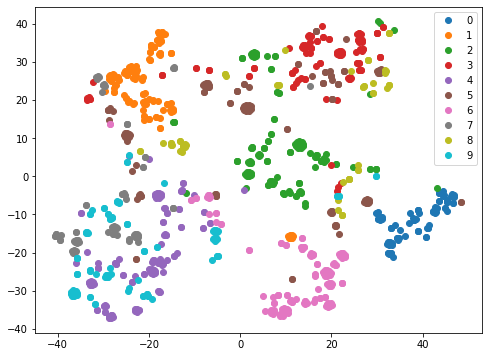

In [24]:
selected_codes = np.random.choice(len(codes),1000)
codes = codes[selected_codes]
labels = labels[selected_codes]

tsne = TSNE(2)
codes_tsne=tsne.fit_transform(codes)

# plotto i codici nello spazio 2D distinguendoli per colore
plt.figure(figsize=(8,6))

for c in np.unique(labels):
        plt.plot(codes_tsne[labels==c, 0], codes_tsne[labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

### Autoencoders basato su convoluzioni
In questo caso il codice non sarà un vettore unidimensionale ma una mappa di feature di dimensione minore rispetto a quella in input.

L'encoder sarà una CNN, con i seguenti accorgimenti:
- Inseriremo padding nelle convoluzioni per evitare di ridurre le dimensioni delle mappe di feature. L'unica operazione che ridurrà le dimensioni delle mappe di feature è il poolin;
- Dato che il nostro obbiettivo non è fare classificazione, utilizzeremo average pooling al posto del max pooling

Il decoder sarà una CNN speculare all'encoder, con la seguente modifica:
- Al posto dell'average pooling che riduce le dimensione dell'input di un fattore $s$, utilizzeremo un modulo di "upsampling" che, mediante interpolazione aumenterà le dimensioni dell'input di un fattore $s$;

Utilizzeremo solo filtri $3 \times 3$ in questo esempio.

Prima di allenare il modello, dobbiamo ridefinire dataset e data loaders evitando di introdurre l'operazione flatten ( `lambda x: x.view(-1)`), in modo da caricare immagini $28 \times 28$ invece di vettori di $784$ elementi:

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean,),(std))
                                ])

mnist_train = MNIST(root='mnist',train=True, download=True, transform=transform)
mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=1024, num_workers=NUM_WORKERS, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=NUM_WORKERS)

# controllo che la shape sia corettamente 28x28
for a in mnist_train_loader:
    print(a[0].shape)
    break

torch.Size([1024, 1, 28, 28])


In [15]:
logger = TensorBoardLogger("tb_logs", name="mnist_conv_autoencoder")
mnist_conv_autoencoder = lib.AutoencoderConv()
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=GPUS, logger=logger)
trainer.fit(mnist_conv_autoencoder, mnist_train_loader, mnist_test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 1.6 K 
1 | decoder   | Sequential | 1.6 K 
2 | criterion | MSELoss    | 0     
-----------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 4: 100%|██████████| 69/69 [00:35<00:00,  1.97it/s, loss=0.142, v_num=1]


(10000, 4, 7, 7) (10000,)
(1000, 196)


/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


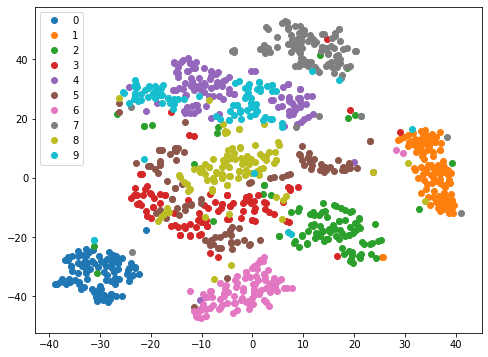

In [7]:
lib.make_TSNE(mnist_conv_autoencoder, mnist_test_loader)

### Denoising autoencoders

Perturbare l'immagine di input chiedendo al modello di ricostruire comunque l'immagine non perturbata. Il principale scopo è evitare che il modello apprenda una funzione identità, che non sarebbe sufficiente a ricostruire l'immagine non perturbata. L'implementazione di un denoising autoencoder è molto semplice: è sufficiente inserire un livello di dropout prima dell'input. Il dropout infatti metterà a zero un certo punto scelti casualmente.

In [3]:
logger = TensorBoardLogger("tb_logs", name="mnist_denoising_conv_autoencoder")

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean,),(std))
                                ])

mnist_train = MNIST(root='mnist',train=True, download=True, transform=transform)
mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=1024, num_workers=NUM_WORKERS, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=NUM_WORKERS)

mnist_denoising_conv_autoencoder = lib.DenoisingConvAutoencoder()
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=GPUS, logger=logger)
trainer.fit(mnist_denoising_conv_autoencoder, mnist_train_loader, mnist_test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 1.6 K 
1 | decoder   | Sequential | 1.6 K 
2 | criterion | MSELoss    | 0     
-----------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 4: 100%|██████████| 69/69 [00:33<00:00,  2.06it/s, loss=0.466, v_num=1]


(10000, 4, 7, 7) (10000,)
(1000, 196)


/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


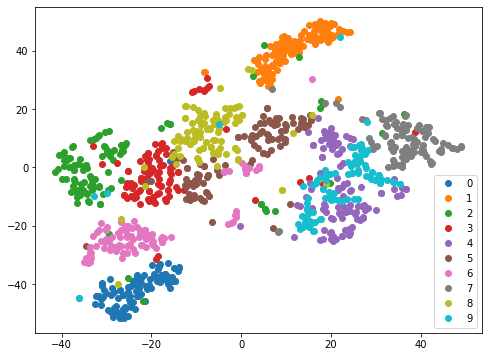

In [4]:
lib.make_TSNE(mnist_denoising_conv_autoencoder, mnist_test_loader)

### Sparse autoencoders

Un altro modo per evitare l'autoencoder apprenda semplicemente la funzione identità, consiste nel limitare le forme che il codice interno all'autoencoder può assumere. In particolare, gli sparse autoencoders impongono un vincolo di sparsità sulle unità del codice. Ciò può essere fatto in diversi modi. Noi vedremo come farlo sommando alla loss una penalità L1.
Se $\hat{\mathbf{z}}$ è il codice e $N$ è la dimensione del codice, il vincolo di sparsità può essere espresso come: $\sum_i^N |\hat{z}_i-s|$, dove $s$ è una piccola costante che indica il parametro di sparsità.
La loss finale è duqnue:
$L(x, \hat{x}, \hat{z}) = MSE(x, M(x)) + \beta \sum_i^N |\hat{z}_i-s|$
Dove $x$ è l'immagine di input, $\hat x$ è quella ricostruita e $\beta$ è un parametro che regola il contributo delle due loss. Vediamo come modificare la definizione dell'autoencoder vista in precedenza per introdurre il vincolo di sparsità:

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean,),(std))
                                ])

mnist_train = MNIST(root='mnist',train=True, download=True, transform=transform)
mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=1024, num_workers=NUM_WORKERS, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=NUM_WORKERS)

# controllo che la shape sia corettamente 28x28
for a in mnist_train_loader:
    print(a[0].shape)
    break

torch.Size([1024, 1, 28, 28])


In [3]:
logger = TensorBoardLogger("tb_logs", name="mnist_sparse_conv_autoencoder")
mnist_sparse_conv_autoencoder = lib.SparseConvAutoencoder()
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=GPUS, logger=logger)
trainer.fit(mnist_sparse_conv_autoencoder, mnist_train_loader, mnist_test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 1.6 K 
1 | decoder   | Sequential | 1.6 K 
2 | criterion | MSELoss    | 0     
3 | l1        | L1Loss     | 0     
-----------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 4: 100%|██████████| 69/69 [00:32<00:00,  2.14it/s, loss=0.222, v_num=1]


(10000, 4, 7, 7) (10000,)
(1000, 196)


/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


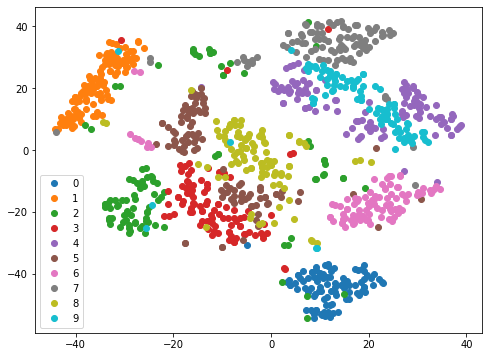

In [4]:
lib.make_TSNE(mnist_sparse_conv_autoencoder, mnist_test_loader)

### Applicazioni
Negli esempi visti finora, abbiamo verificato se gli autoencoder allenati fossero in grado di ricostruire correttamente l'input e costruire uno spazio di rappresentazione in cui elementi della stessa classe fossero vicini. Vediamo adesso alcuni esempi di applicazioni di autoencoder.
Vedremo i seguenti esempi di applicazione

#### 1. Unsupervised representation learning

Un autoencoder permette di apprendere rappresentazioni dell'input in maniera non supervisionata (non sono necessarie le etichette per il training). Per verificare che le rappresentazioni apprese sono in effetti buone per la classificazione, proveremo ad allenare un semplice classificatore nearest neighbor utilizando un piccolo sottoinsieme di 100 codici estratti. Se la rappresentazione è sufficientemente buona, il classificatore avrà buone performance anche con un insieme limitati di dati. Confronteremo questo approccio con un nearest neighbor applicato direttamente alle immagini (intesi come valori dei pixel).


Iniziamo estraendo i codici di training e di test usando l'ultimo modello allenato. Selezioneremo un sottoinsieme di 100 esempi di training presi casualmente.

Alleno un classificatore 1-NN per visualizzare l'accuracy sul test-set

In [8]:
# rifaccio alcuni passaggi della parte precedente perché devo estrarre i codici prima senza plottare il risultato

codes, labels = lib.extract_codes(mnist_sparse_conv_autoencoder, mnist_test_loader)

selected_codes = np.random.choice(len(codes),1000)
codes = codes.reshape(codes.shape[0],-1)
codes = codes[selected_codes]
labels = labels[selected_codes]

In [9]:
codes_train, labels_train = lib.extract_codes(mnist_sparse_conv_autoencoder, mnist_train_loader)
codes_train = codes_train.reshape(codes_train.shape[0],-1)

selected_codes = np.random.choice(len(codes),100)
codes_train = codes[selected_codes]
labels_train = labels[selected_codes]

codes_test, labels_test = lib.extract_codes(mnist_sparse_conv_autoencoder, mnist_test_loader)
codes_test = codes_test.reshape(codes_test.shape[0],-1)

In [10]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(codes_train, labels_train)
knn.score(codes_test, labels_test)

0.7361

In [11]:
images_train = np.vstack([mnist_train[i][0].view(-1) for i in selected_codes])
labels_train = np.hstack([mnist_train[i][1] for i in selected_codes])

images_test = np.vstack([mnist_test[i][0].view(-1) for i in range(len(mnist_test))])
labels_test = np.hstack([mnist_test[i][1] for i in range(len(mnist_test))])

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(images_train, labels_train)
knn.score(images_test, labels_test)

0.649

#### 2. Dimensionality reduction

Gli autoencoder permettono anche di ridurre la dimensionalità dei dati di input. Infatti, dato che l'autoencoder è capace di ricostruire le immagini di input dai codici, è possibile conservare i codici in luogo delle immagini riducendone la dimensione e risparmiando spazio. La riduzione della dimensione può essere anche utile per ridurre i requisiti computazionali di un possibile algoritmo che lavorerà sui codici piuttosto che sulle immagini. Vediamo con un semplice esempio quanto spazio possiamo risparmiare conservando i codici invece delle immagini.
Iniziamo confrontando lo spazio occupato in memoria in numero di byte dal test set quando conservato come immagini e quando conservato come codici. Utilizzeremo il primo autoencoder, che ha dei codici più piccoli:

In [5]:
for batch in mnist_test_loader:
    break

batch[0].shape

torch.Size([1024, 784])

In [6]:
# estraiamo i codici
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean,),(std,)),
                                torch.flatten])

mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=2)
codes_test, labels_test = lib.extract_codes(mnist_autoencoder, mnist_test_loader)

#rappresentiamo le immagini a 8 bit
mnist_test_raw = MNIST(root='mnist',train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x*255)]))

images_test_raw = np.vstack([mnist_test_raw[i][0].view(-1) for i in range(len(mnist_test_raw))]).astype(np.uint8)

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


In [8]:
print(f"Dimensione occupata dalle immagini: {images_test_raw.nbytes}")
print(f"Dimensione occupata dai codici: {codes_test.nbytes}")
print(f"Rapporto di compressione: {100-codes_test.nbytes/images_test_raw.nbytes*100:0.2f}%")

Dimensione occupata dalle immagini: 7840000
Dimensione occupata dai codici: 5120000
Rapporto di compressione: 34.69%


una volta conservati i codici, possiamo ricostruier le immagini in input usando solo il decoder

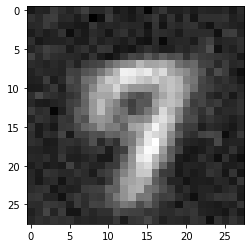

In [10]:
decoder = mnist_autoencoder.decoder

def decode(code):
    output_image = decoder(code)
    #l'immagine in output è normalizzata come quelle che abbiamo passato in input #invertiamo la normalizzazione:
    return output_image*0.3081 + 0.1307

# visualizzo la ricostruzione del codice
out_img=decode(torch.from_numpy(codes_test.copy())).reshape(-1,1,28,28)
plt.imshow(out_img[0][0].detach().cpu(), cmap='gray')

#### 3. Anomaly detection
L'anomaly detection è un'altra potenziale applicazione degli autoencoder. Una volta allenato un autoencoder con immagini appartenenti a una distribuzione (es. la distribuzione delle immagini di MNIST), ci aspettiamo che esso sia molto efficace nel codificare e ricostruire queste immagini e meno efficace nel codificare e ricostruire immagini di un altro dominio.
Vediamo ad esempio come le immagini del dataset FashionMNIST vengono ricostruite con il Convolutional Autoencoder allenato su MNIST. Iniziamo definendo il dataset FashionMNIST. Utilizzeremo le stesse trasformazioni con le quali è stato allenato il modello (e quindi media e deviazione standard di MNIST):

In [12]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((mean,), (std,))])

fashion_train = FashionMNIST(root='fashion', download=True, transform=transform)
fashion_train_loader = DataLoader(fashion_train, batch_size=1024)

26422272it [00:11, 2272208.92it/s]                              


Extracting fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion/FashionMNIST/raw



29696it [00:00, 568444.06it/s]           


Extracting fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion/FashionMNIST/raw



4422656it [00:02, 2201374.25it/s]                             


Extracting fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion/FashionMNIST/raw



6144it [00:00, 8270155.26it/s]          

Extracting fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion/FashionMNIST/raw



Vediamo ora un esempio di ricostruzione di una immagine di FashionMNIST. Calcoleremo anche la norma L2 tra le due immagini (input e ricostruita) per capire quanto sono dissimili:

Distanza fra le immagini:  20.11


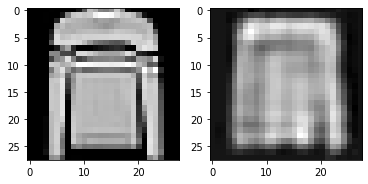

In [16]:
im_in_fashion = fashion_train[5][0]
code, im_out_fashion = mnist_conv_autoencoder(im_in_fashion.unsqueeze(0))

plt.subplot(1,2,1)
plt.imshow(im_in_fashion.squeeze().detach(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im_out_fashion.squeeze().cpu().detach(), cmap='gray')
print(f"Distanza fra le immagini: {(im_in_fashion.cpu()-im_out_fashion.cpu()).norm(2): 0.2f}")

Distanza fra le immagini: 10.68


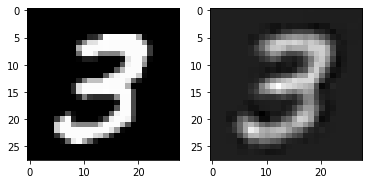

In [20]:
im_in_mnist = mnist_train[7][0]
code, im_out_mnist = mnist_conv_autoencoder(im_in_mnist.unsqueeze(0))
plt.subplot(1,2,1)
plt.imshow(im_in_mnist.squeeze().detach(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im_out_mnist.squeeze().cpu().detach(), cmap='gray')
print(f"Distanza fra le immagini: {(im_in_mnist.cpu()-im_out_mnist.cpu()).norm(2):0.2f}")

Vediamo adesso se quanto osservato per le immagini di esempio si verifica sistematicamente o meno. Lo faremo calcolando la norma L2 media tra input e output per i due dataset:

In [22]:
from tqdm import tqdm

norms_fashion = []

for im, _ in tqdm(fashion_train_loader):
    _, im_out = mnist_conv_autoencoder(im)
    n=(im-im_out.cpu()).view(im.shape[0],-1).norm(2, dim=-1)
    norms_fashion.append(n.detach().numpy())

norms_fashion = np.concatenate(norms_fashion)
print("Media delle norme L2 per FashionMNIST:",norms_fashion.mean())

100%|██████████| 59/59 [00:17<00:00,  3.43it/s]

Media delle norme L2 per FashionMNIST: 15.461126


In [24]:
norms_mnist=[]
for im, _ in tqdm(mnist_train_loader):
    _, im_out = mnist_conv_autoencoder(im)
    n=(im-im_out.cpu()).view(im.shape[0],-1).norm(2, dim=-1)
    norms_mnist.append(n.detach().numpy())
norms_mnist = np.concatenate(norms_mnist)
print("Media delle norme L2 per MNIST:",norms_mnist.mean())

100%|██████████| 59/59 [00:17<00:00,  3.47it/s]

Media delle norme L2 per MNIST: 10.352477


Come è possibile vedere, le norme L2 per MNIST tendono ad essere più basse. Possiamo visualizzarlo anche mediante dei boxplot:

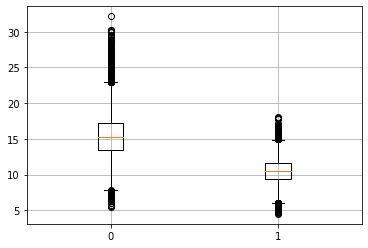

In [25]:
plt.figure()
plt.boxplot([norms_fashion, norms_mnist], positions=[0,1])
plt.grid()
plt.show()

Se volessimo costruire un sistema di anomaly detection, potremmo semplicemente allenare un regressore logistico sulle norme L2:

In [26]:
from sklearn.linear_model import LogisticRegression

#gli elementi in input saranno tutte le norme L2
x_train = np.concatenate([
        norms_fashion,
        norms_mnist
    ]).reshape(-1,1)
#definiamo le etichette
y_train = np.concatenate([
        np.ones_like(norms_fashion)*-1, #negative examples: fashion 
        np.ones_like(norms_mnist),#positive examples
    ]).reshape(-1,1)
lr = LogisticRegression()
lr.fit(x_train, y_train)

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Scriviamo adesso una funzione che prende una immagine e la classifica come positivo (appartenente alla classe MNIST) o negativo (non appartenente a MNIST - anomalia):

In [27]:
def detect_anomaly(example):
    _, im_out = mnist_conv_autoencoder(example.unsqueeze(0))
    return lr.predict((im_out.cpu()-example).norm(2).detach().numpy().reshape(-1,1))

Definiamo i dataset di set e testiamo la funzione sui 1000 elementi casuali di ciascun dataset:

In [28]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])
mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)
fashion_test = FashionMNIST(root='fashion', train=False, download=True, transform=transform)

Adesso testiamo sui 1000 elementi selezionati casualmente:

In [29]:
predictions_mnist = []
predictions_fashion = []
for i in tqdm(np.random.choice(len(mnist_test), 1000)):
    prediction_mnist = detect_anomaly(mnist_test[i][0])
    prediction_fashion = detect_anomaly(fashion_test[i][0])
    predictions_mnist.append(prediction_mnist)
    predictions_fashion.append(prediction_fashion)

predictions_mnist = np.array(predictions_mnist)
predictions_fashion = np.array(predictions_fashion)

print(f"Percentuale di elementi di MNIST classificati correttamente: {(predictions_mnist==1).mean()*100:0.2f}%")
print(f"Percentuale di elementi di Fashion-MNIST classificati correttamente: {(predictions_fashion==-1).mean()*100:0.2f}%")

100%|██████████| 1000/1000 [00:01<00:00, 574.34it/s]

Percentuale di elementi di MNIST classificati correttamente: 91.20%
Percentuale di elementi di Fashion-MNIST classificati correttamente: 84.80%
